In [2]:
import pandas as pd
import h5py
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import joblib

In [3]:
keys = ['hydro_07ED002', 'hydro_07EF002', 'hydro_07EF003', 'hydro_08GB013', 'hydro_08HB082', 'hydro_08HD025', 'hydro_08JA022', 'hydro_08JA023', 'hydro_08JA027', 'hydro_08LC018', 'hydro_08LC041', 'hydro_08ME017', 'hydro_08MH141', 'hydro_08MH148', 'hydro_08MH149', 'hydro_08MH167', 'hydro_08NB017', 'hydro_08ND017', 'hydro_08NE102', 'hydro_08NE103', 'hydro_08NE104', 'hydro_08NE107', 'hydro_08NH064', 'hydro_08NH067', 'hydro_08NH127', 'hydro_08NM213', 'hydro_08NM234']
# for key in keys:
#         my_hdf = pd.read_hdf('combined_data.hdf', key=key)
#         print(key, len(my_hdf), len(my_hdf.dropna()))

In [62]:
def plot_errors(model, X_valid, y_valid, output_filename):
    plt.hist(y_valid - model.predict(X_valid), bins=100)
    plt.savefig('models/errors_{}.png'.format(output_filename))
    plt.close()

def plot_model(X_vals, y_vals, model, output_filename):
    plt.plot(X_vals['date'], y_vals, 'b.', alpha=0.5)
    plt.scatter(X_vals['date'], model.predict(X_vals), s=1, alpha=0.5, c='r')
    plt.show()
    plt.savefig('models/predict_{}.png'.format(output_filename))
    plt.close()
    
def plot_df_vals(df):
    scaled_df = pd.DataFrame(StandardScaler().fit_transform(df))
    scaled_df.columns = df.columns
    scaled_df.index = df.index
    plt.plot(scaled_df.index, scaled_df['water_level'], c= 'b')
    plt.plot(scaled_df.index, scaled_df['precip'], c= 'r')
    plt.plot(scaled_df.index, scaled_df['rain'], c= 'yellow')
    plt.plot(scaled_df.index, scaled_df['mean_temp'], c='g')
    plt.plot(scaled_df.index, scaled_df['snow_precip'], c='aqua')
    plt.plot(scaled_df.index, scaled_df['snow_on_grnd'], c='magenta')
    
def model_scores(model, X_train, X_valid, y_train, y_valid):
    return {'train_score': model.score(X_train, y_train), 'valid_score': model.score(X_valid, y_valid)}

def train_and_generate_model(X_train, y_train, C=1, n_components=4):
    imputer = SimpleImputer()
    scaler = StandardScaler()
    model = make_pipeline(
        imputer,
        scaler,
        PCA(n_components=n_components), # assume we have some kind of time, precip and temp dimensionality
        SVR(C=C, gamma='scale')
    )
    model.fit(X_train, y_train)
    return model

def prepare_df(df):
    df['date'] = df.index.map(dt.datetime.toordinal)
    X_columns = ['date','year', 'month', 'rain', 'precip', 'mean_temp', 'snow_on_grnd', 'snow_precip']
    y_column = 'water_level'
    X = df[X_columns]
    y = df['water_level'].values
    return (X, y)

In [59]:
SAVE_MODELS = False

hydro_07ED002 {'train_score': 0.7511584773610034, 'valid_score': 0.7303600264718644}


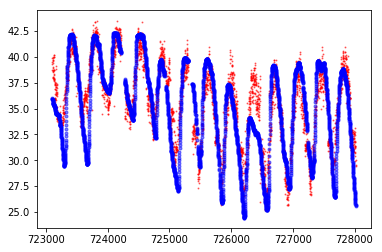

hydro_07EF002 {'train_score': 0.6338888285596715, 'valid_score': 0.6510911590385662}


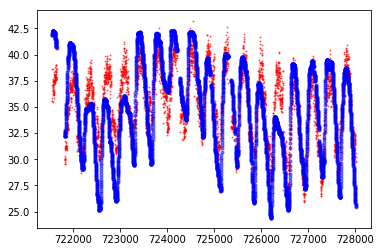

hydro_07EF003 {'train_score': 0.7555969146563626, 'valid_score': 0.7140637659466825}


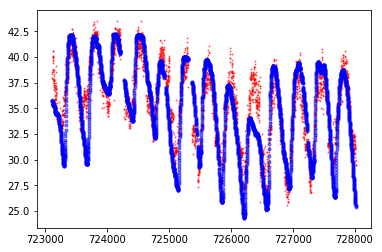

hydro_08GB013 ignored


In [ ]:
for key in keys:
    df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
    if len(df) == 0:
        print(key, 'ignored')
        continue
    X, y = prepare_df(df)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    
    model = train_and_generate_model(X_train, y_train)
    print(key, model_scores(model, X_train, X_valid, y_train, y_valid))
    plot_model(X, y, model, key)
    if SAVE_MODELS:
        joblib.dump(model, 'models/model-{}.pckl'.format(key))
    #plot_errors(model, X_valid, y_valid, key)

In [ ]:
# k1 = 5.0**2 * RBF(length_scale=3.0) *  ExpSineSquared(length_scale=1.3, periodicity=1.0)  # long term smooth rising trend
#k_years = 10**2 * RBF(length_scale=3.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=3**2)  # noise terms
#k = k_years


In [10]:
# model notes
"""
drought-year outlier handling needs work
check for distribution along month? strong comp
C as a function of the mean? not if we scale
Figure out keeping labels but scaling the other stuff
coquitlam lake??? snowfall
compare models when training on monthly subsets of the data
group into months and then train models5
"""

'\ndrought/year outlier handling needs work\ncheck for distribution along month? strong comp\nC as a function of the mean\n'

hydro_08MH149 {'train_score': 0.2941930600571556, 'valid_score': 0.2772765764890077}


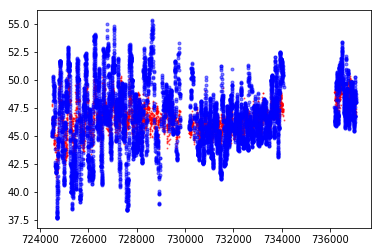

In [64]:
key = 'hydro_08MH149'
df = pd.read_hdf('combined_data.hdf', key=key).sort_index().dropna()
if len(df) == 0:
    print(key, 'ignored')
X, y = prepare_df(df)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

model = train_and_generate_model(X_train, y_train, C=1)
print(key, model_scores(model, X_train, X_valid, y_train, y_valid))
plot_model(X, y, model, key)
if SAVE_MODELS:
    joblib.dump(model, 'models/model-{}.pckl'.format(key))

In [56]:
X['date']

1984-08-29    724517
1984-08-30    724518
1984-08-31    724519
1984-09-01    724520
1984-09-02    724521
               ...  
2018-12-27    737055
2018-12-28    737056
2018-12-29    737057
2018-12-30    737058
2018-12-31    737059
Name: date, Length: 8418, dtype: int64

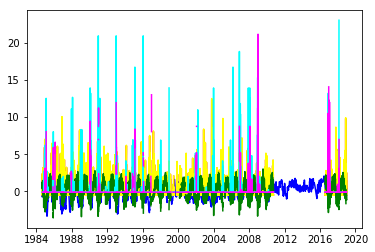

In [9]:
df = df = pd.read_hdf('combined_data.hdf', key='hydro_08MH149').sort_index()#.dropna()

plot_df_vals(df)

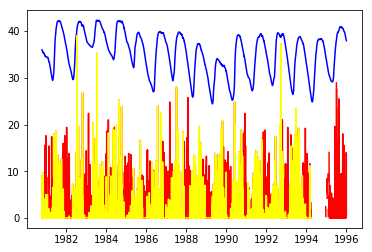

In [41]:
plt.plot(df.index, df['water_level'], c= 'b')
plt.plot(df.index, df['precip'], c= 'r')
plt.plot(df.index, df['rain'], c= 'yellow')
#plt.plot(df.index, df['mean_temp'], c='g')
#plt.plot(df.index, df['snow_precip'], c='aqua')
#plt.plot(df.index, df['snow_on_grnd'], c='magenta')
#weekdays and weekends

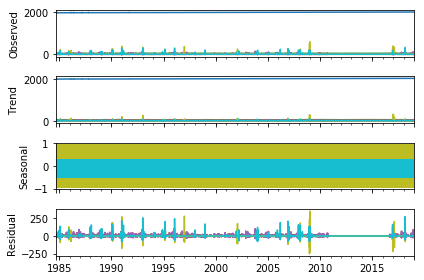

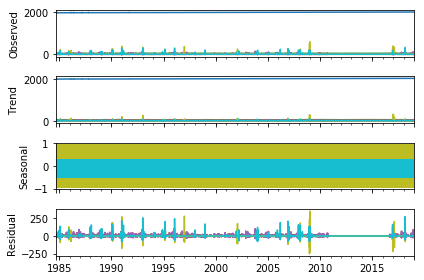

In [93]:
df = pd.read_hdf('combined_data.hdf', key='hydro_08MH149').sort_index()
X = df.asfreq('D')
imputed_df = pd.DataFrame(SimpleImputer().fit_transform(X))
imputed_df.columns = X.columns
imputed_df.index = X.index

seasonal_decompose(imputed_df).plot() #???

In [60]:
imputed_df.asfreq('D')

,date,year,month,rain,precip,mean_temp,snow_on_grnd,snow_precip
1984-08-29,724517.0,1984.0,8.0,0.000000,0.000000,14.50000,0.000000,0.000000
1984-08-30,724518.0,1984.0,8.0,0.000000,0.000000,16.00000,0.000000,0.000000
1984-08-31,724519.0,1984.0,8.0,4.000000,4.000000,14.80000,0.000000,0.000000
1984-09-01,724520.0,1984.0,9.0,0.000000,0.000000,14.30000,0.000000,0.000000
1984-09-02,724521.0,1984.0,9.0,0.000000,0.000000,13.80000,0.000000,0.000000
1984-09-03,724522.0,1984.0,9.0,0.000000,0.000000,18.00000,0.000000,0.000000
1984-09-04,724523.0,1984.0,9.0,22.200000,22.200000,15.00000,0.000000,0.000000
1984-09-05,724524.0,1984.0,9.0,30.600000,30.600000,13.80000,0.000000,0.000000
1984-09-06,724525.0,1984.0,9.0,0.000000,0.000000,13.50000,0.000000,0.000000
1984-09-07,724526.0,1984.0,9.0,0.000000,0.000000,12.30000,0.000000,0.000000


In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose